Implementing stepLR to fine tune learning rate to converge faster

In [ ]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ≈

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0,7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
def model_summary():
  model = Net().to(device)
  summary(model, input_size=(1, 28, 28))

def plot_result():
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
class Net(nn.Module):

    def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
      return nn.Sequential(
            nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.01))
        
    def out_block(self, in_channels, kernel_size = 1):
      return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))


    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = self.conv_block(1, 10, 3)
        self.conv2 = self.conv_block(10, 10, 3, 0)
        self.conv3 = self.conv_block(10, 11, 3)
        self.conv4 = self.conv_block(11, 11, 3, 0)
        self.conv5 = self.conv_block(11, 12, 3)
        self.conv6 = self.conv_block(12, 12, 3, 0)
        self.conv8 = self.out_block(12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 26, 26]             900
              ReLU-6           [-1, 10, 26, 26]               0
       BatchNorm2d-7           [-1, 10, 26, 26]              20
           Dropout-8           [-1, 10, 26, 26]               0
         MaxPool2d-9           [-1, 10, 13, 13]               0
           Conv2d-10           [-1, 11, 13, 13]             990
             ReLU-11           [-1, 11, 13, 13]               0
      BatchNorm2d-12           [-1, 11, 13, 13]              22
          Dropout-13           [-1, 11, 13, 13]               0
           Conv2d-14           [-1, 11,

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10305903106927872 Batch_id=468 Accuracy=90.24: 100%|██████████| 469/469 [00:50<00:00,  9.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.09793897718191147 Batch_id=468 Accuracy=95.69: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9891/10000 (98.91%)

EPOCH: 2


Loss=0.10181567817926407 Batch_id=468 Accuracy=96.65: 100%|██████████| 469/469 [00:49<00:00,  9.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9866/10000 (98.66%)

EPOCH: 3


Loss=0.12833215296268463 Batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:49<00:00,  9.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9865/10000 (98.65%)

EPOCH: 4


Loss=0.13733965158462524 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:49<00:00,  9.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9886/10000 (98.86%)

EPOCH: 5


Loss=0.04715543985366821 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:50<00:00,  9.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.03614595904946327 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:50<00:00,  9.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.016177715733647346 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:49<00:00,  9.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 8


Loss=0.04221433773636818 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:50<00:00,  9.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.05101686716079712 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:49<00:00,  9.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.14356571435928345 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.10706128925085068 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:50<00:00,  9.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9942/10000 (99.42%)

EPOCH: 12


Loss=0.03795357421040535 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:50<00:00,  9.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9951/10000 (99.51%)

EPOCH: 13


Loss=0.016353664919734 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:50<00:00,  9.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9952/10000 (99.52%)

EPOCH: 14


Loss=0.06613392382860184 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]



Test set: Average loss: 0.0192, Accuracy: 9948/10000 (99.48%)



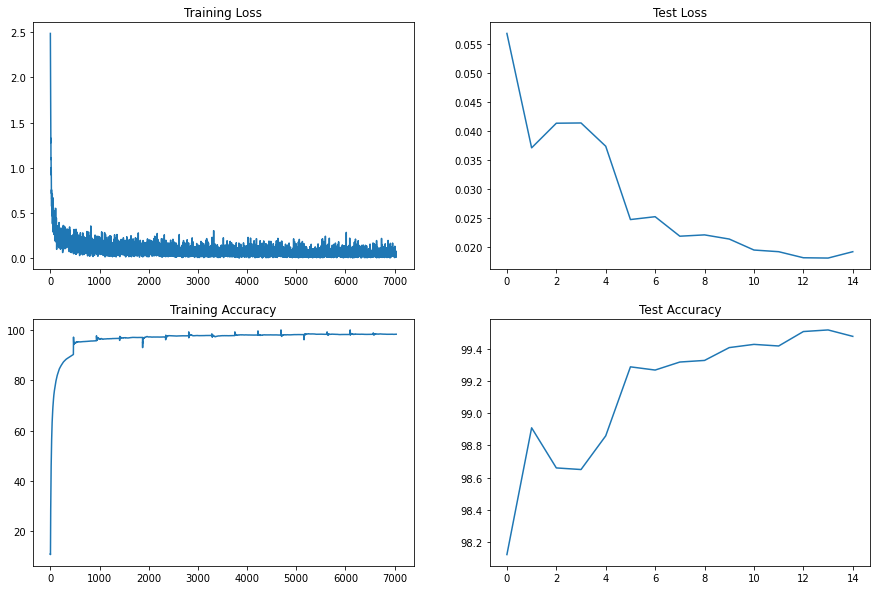

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

plot_result()

## Results:

<b>Parameters:</b> 6,765

<b>Best Train Accuracy:</b> 98.30

<b>Best Test Accuracy:</b> 99.52

<b>Analysis:</b>
We have fine tuned dropout from 0.02 to 0.01. Using StepLR and starting learning rate at 0.1 and reducing by 0.5 after every 5th epoch. Based on the result learning rate has helped acheive test accuracy much faster and consistently

Problem : We had runned this network multiple times and was not able to hit the same accuracy again and again the accuracy varied from 99.39 to 99.52, but every time the result where consistent